Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


C:\Users\lelow\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 935s 5s/step - accuracy: 0.8068 - loss: 0.9255 - val_accuracy: 0.9444 - val_loss: 0.1544
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 977s 5s/step - accuracy: 0.9704 - loss: 0.0815 - val_accuracy: 0.9762 - val_loss: 0.1203
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1015s 5s/step - accuracy: 0.9836 - loss: 0.0517 - val_accuracy: 0.9737 - val_loss: 0.1453
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1035s 5s/step - accuracy: 0.9866 - loss: 0.0373 - val_accuracy: 0.9794 - val_loss: 0.1324
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.9937 - loss: 0.0216 - val_accuracy: 0.9812 - val_loss: 0.0709
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 971s 5s/step - accuracy: 0.9928 - loss: 0.0209 - val_accuracy: 0.9837 - val_loss: 0.0785
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 996s 5s/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9844 - val_loss: 0.0451
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 978s 5s/step - accuracy: 0.9934 - loss: 0.0175 - val_ac

✅ Modell erfolgreich trainiert und gespeichert!
50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step


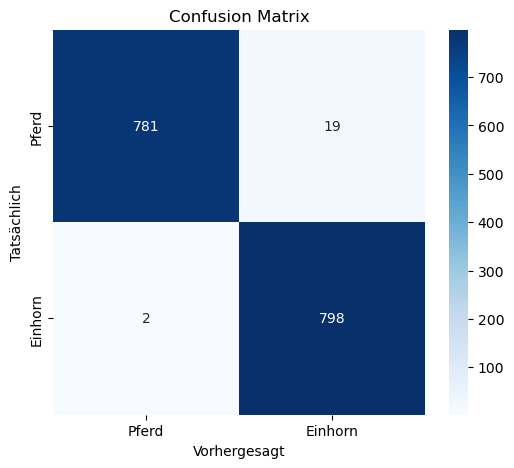

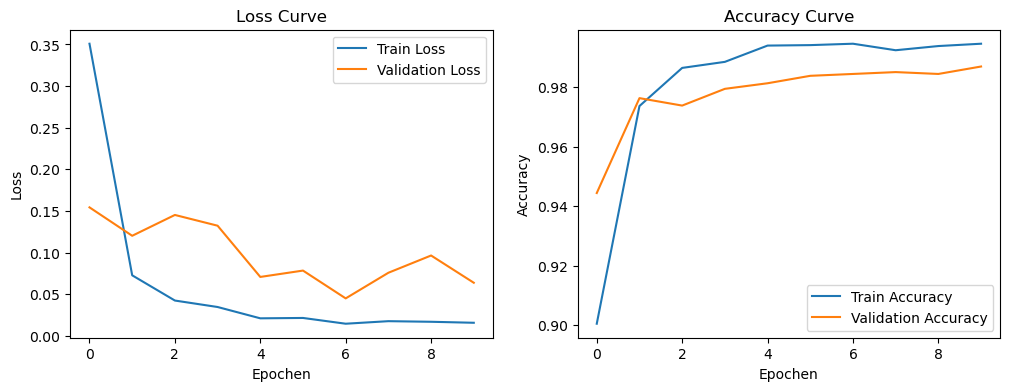

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  # Für das Laden einzelner Bilder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Verzeichnisse für die Bilder
train_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/train"
test_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/test"
img_size = (256, 256)  
batch_size = 32

# Datenvorverarbeitung mit Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

# Vortrainiertes VGG16-Modell laden
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

# Klassifikationsschichten hinzufügen
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
history = model.fit(train_generator, validation_data=test_generator, epochs=10)

# Modell speichern
model.save("horse_vs_unicorn_vgg16.keras")
print("✅ Modell erfolgreich trainiert und gespeichert!")

# Funktion zur Vorhersage eines einzelnen Bildes
def predict_single_image(image_path, model_path="horse_vs_unicorn_vgg16.h5"):
    model = load_model(model_path)
    img = load_img(image_path, target_size=(256, 256))  # Bild laden und skalieren
    img_array = img_to_array(img) / 255.0  # Normalisieren
    img_array = np.expand_dims(img_array, axis=0)  # Batch-Dimension hinzufügen
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print(f"🚀 Das Modell erkennt ein 🦄 EINHORN mit {prediction:.2%} Wahrscheinlichkeit")
    else:
        print(f"🏇 Das Modell erkennt ein 🐴 PFERD mit {(1 - prediction):.2%} Wahrscheinlichkeit")

# Beispielaufruf:
# predict_single_image("pfad/zum/bild.jpg")

# Confusion Matrix berechnen
y_true = test_generator.classes  # Tatsächliche Klassen aus Testdaten
y_pred_probs = model.predict(test_generator)  # Vorhergesagte Wahrscheinlichkeiten
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # In 0 oder 1 umwandeln

# Confusion Matrix anzeigen
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Pferd", "Einhorn"], yticklabels=["Pferd", "Einhorn"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()

# Loss & Accuracy Curve
plt.figure(figsize=(12, 4))

# Verlust (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Genauigkeit (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


# Modell Architektur anzeigen

In [4]:


from tensorflow.keras.models import load_model


model = load_model("horse_vs_unicorn_vgg16.keras")


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,983,813 (129.64 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,846,084 (49.00 MB)

# Imports

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Pfad zu den Datensätzen und Bildergröße sowie die Batchgröße

In [73]:
train_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/train"
test_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/test"
img_size = (256, 256)  
batch_size = 32

# Datenvorverarbeitung mit Image Augmentation

#Bilddaten werden geladen, skaliert und in Batches verarbeitet
#Trainingsdaten werden gemischt aber Testdaten nicht
#Pixelwerte von 0 bis 255 auf einen Bereich zwischen 0 und 1 skaliert

In [76]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary", shuffle=False
)


Found 9600 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


# Vortrainiertes VGG16-Modell laden

In [78]:

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Klassifikationsschichten und das Modell kompilieren

#Erweiterung des vortrainierten Modells von gerade mit neuen Schichten
#Flatten Layer -> Dense (256 Neuronen mit Aktivierungsfunktion ReLU) -> Dropout (0.5) -> Dense (1 Neuron mit Sigmoid)
#Adam und Binary für die binäre Klassifikation
#Modell ist vorbereitet für das Training und das Testen

In [81]:
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early Stopping wenn Model overfittet


#Early Stopping, wenn das "val_loss" in den letzten 3 Epochen nicht niedriger geworden ist -> anzeichen Overfitting

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)


history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  
    callbacks=[early_stopping]  
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1496s 5s/step - accuracy: 0.8751 - loss: 0.5287 - val_accuracy: 0.9479 - val_loss: 0.1228
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1476s 5s/step - accuracy: 0.9820 - loss: 0.0545 - val_accuracy: 0.9750 - val_loss: 0.0589
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1461s 5s/step - accuracy: 0.9878 - loss: 0.0368 - val_accuracy: 0.9617 - val_loss: 0.0905
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1460s 5s/step - accuracy: 0.9903 - loss: 0.0245 - val_accuracy: 0.9846 - val_loss: 0.0368
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1460s 5s/step - accuracy: 0.9941 - loss: 0.0154 - val_accuracy: 0.9854 - val_loss: 0.0405
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1471s 5s/step - accuracy: 0.9902 - loss: 0.0282 - val_accuracy: 0.9854 - val_loss: 0.0357
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1473s 5s/step - accuracy: 0.9916 - loss: 0.0231 - val_accuracy: 0.9804 - val_loss: 0.0606
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1482s 5s/step - accuracy: 0.9919 - loss: 0.0242 - 

# Modell wird gespeichert

In [ ]:
model.save("horse_vs_unicorn_vgg16_20_Epochen.keras")
print("Modell gespeichert und trainiert!")

# Funktion zur Vorhersage eines einzelnen Bildes außerhalb des normalen Datensatzes

#Trainiertes Modell wird geladen
#Bild wird skaliert auf 256x256 Pixel 
#Das Bild wird in ein NumPy-Array umgewandelt (weil DL arbeitet besser mit normalisierten Werten)
#Die Dimension des Arrays wird erweitert, da das Modell eine Batch-Dimension (1. Achse) erwartet
#Das neue Bild wird durch das Modell geschickt und gibt eine einzelne Zahl zurück
#If Funktion sagt an ob es sich um ein Pferd oder Einhorn handelt

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Funktion zur Vorhersage eines einzelnen Bildes
def predict_einzelnes_bild(image_path, model_path="horse_vs_unicorn_vgg16_20_Epochen.keras"):
    model = load_model(model_path)
    img = load_img(image_path, target_size=(256, 256))  # Bild laden und skalieren
    img_array = img_to_array(img) / 255.0  # Normalisieren
    img_array = np.expand_dims(img_array, axis=0)  # Batch-Dimension hinzufügen
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print(f"Das Modell erkennt ein EINHORN mit {prediction:.2%} Wahrscheinlichkeit")
    else:
        print(f"Das Modell erkennt ein PFERD mit {(1 - prediction):.2%} Wahrscheinlichkeit")


# Abruf der oberen Methode für ein einzelnes Bild. Pfad muss angegeben werden

In [ ]:

predict_einzelnes_bild(r"C:\Users\lelow\Documents\horse_vs_unicorn_data\Dunkelfuchs_Equine74_low.jpg")


# Confusion Matrix berechnen und diese auch visuell Anzeigen lassen 

In [ ]:

y_true = test_generator.classes  
y_pred_probs = model.predict(test_generator)  
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pferd", "Einhorn"], yticklabels=["Pferd", "Einhorn"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()

# Loss und Accuracy Kurve berechnen und Anzeigen lassen visuell nach dem Durchlauf

In [ ]:

plt.figure(figsize=(12, 4))

# Verlust 
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Genauigkeit
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochen")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

# Over Accurarcy, TPR und Prescion berechnen

In [ ]:

from sklearn.metrics import precision_score, recall_score

y_true = test_generator.classes  
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)


y_pred = (y_pred > 0.5).astype(int)


precision = precision_score(y_true, y_pred)
tpr = recall_score(y_true, y_pred) 


overall_accuracy = model.evaluate(test_generator)[1]

# Ergebnisse
print(f"Overall Accuracy: {overall_accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"True Positive Rate (TPR): {tpr:.2%}")


In [ ]:
from tensorflow.keras.models import load_model


model = load_model("horse_vs_unicorn_vgg16_20_Epochen.keras")


model.summary()

# Ensemble 

#Training von 3 Varianten von einem VGG-16 Modells
#Die Dropout-Rate und Anzahl der Neuronen in der Dense-Schicht unterscheiden sich bei jedem Modell (dropout: 0,3; 0,5; 0,7 / Neuronen: 128; 256; 512)
#Werden mit 5 Epochen Trainiert
#Modelle werden alle einzeln gespeichert 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


train_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/train"
test_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/test"
img_size = (256, 256)  # Skalierung auf 256x256
batch_size = 32


train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")


def create_vgg16_model(dropout_rate=0.5, dense_neurons=256):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  

    x = Flatten()(base_model.output)
    x = Dense(dense_neurons, activation="relu")(x)
    x = Dropout(dropout_rate)(x)  # Unterschiedliche Dropout-Raten testen
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# drei Modelle trainieren
configs = [
    {"dropout_rate": 0.3, "dense_neurons": 128, "name": "vgg16_model_1.keras"},
    {"dropout_rate": 0.5, "dense_neurons": 256, "name": "vgg16_model_2.keras"},
    {"dropout_rate": 0.7, "dense_neurons": 512, "name": "vgg16_model_3.keras"},
]

for config in configs:
    print(f"Training {config["name"]} mit Dropout={config["dropout_rate"]} und {config["dense_neurons"]} Neuronen...")
    model = create_vgg16_model(config["dropout_rate"], config["dense_neurons"])
    model.fit(train_generator, validation_data=test_generator, epochs=5)  
    model.save(config["name"])  # Modell speichern
    print(f"{config["name"]} gespeichert!\n")


# Testung von den 4 Modellen bei einem Foto

#Lädt die trainierten Modelle 
#Führt bei jedem Modell mit dem Bild eine Vorhersage durch
#Gibt eine Vorhersage aus basierend auf den 5 Modellen

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def ensemble_predict(image_path, model_paths):
    img = load_img(image_path, target_size=(256, 256))  
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = []
    
    for model_path in model_paths:
        model = load_model(model_path)
        pred = model.predict(img_array)[0][0]
        predictions.append(pred)
    
    final_prediction = np.mean(predictions)  

    if final_prediction > 0.5:
        print(f"Das Modell erkennt ein **EINHORN** mit {final_prediction:.2%} Wahrscheinlichkeit")
    else:
        print(f"Das Modell erkennt ein **PFERD** mit {1 - final_prediction:.2%} Wahrscheinlichkeit")

# Vorhersage ausführen
model_list = ["horse_vs_unicorn_vgg16_20_Epochen.keras","vgg16_model_1.keras", "vgg16_model_2.keras", "vgg16_model_3.keras"]
ensemble_predict(r"C:\Users\lelow\Documents\horse_vs_unicorn_data\Dunkelfuchs_Equine74_low.jpg", model_list)


# Neue Aktivierungsfunktion testen

#Neues Vortrainiertes Modell mit VGG-16 was mit 5 Epochen trainiert wird
#Unterschied zu vorherigen Modellen ist das Aktivierungsfunktion LeakyRelu benutzt wird anstatt Relu

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


train_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/train"
test_dir = "C:/Users/lelow/Documents/horse_vs_unicorn_data/test"
img_size = (224, 224)  
batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1.0/255,   
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)


base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False


x = Flatten()(base_model.output)  
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x) 
x = Dropout(0.5)(x)  
x = Dense(1, activation="sigmoid")(x)  


model = Model(inputs=base_model.input, outputs=x)


model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])


history = model.fit(train_generator, validation_data=test_generator, epochs=5)


model.save("new_horse_vs_unicorn_vgg16_with_leakyrelu.keras")


model.summary()

# Confusion Matrix berechnen
y_true = test_generator.classes  # Tatsächliche Klassen aus Testdaten
y_pred_probs = model.predict(test_generator)  # Vorhergesagte Wahrscheinlichkeiten
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # In 0 oder 1 umwandeln

# Confusion Matrix anzeigen
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pferd", "Einhorn"], yticklabels=["Pferd", "Einhorn"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()

# Loss & Accuracy Curve
plt.figure(figsize=(12, 4))

# Verlust (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Genauigkeit (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochen")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()
